In this notebook, we want to:

- investigate the spatial structure of the residual stream
- see which tokens the different directions in the residual stream map to

# setup


In [1]:
# Generic
import os
from pathlib import Path
from copy import deepcopy
import typing
import itertools
from collections import Counter

# Numerical Computing
import numpy as np
import torch
import pandas as pd
# import torch.nn.functional as F
from fancy_einsum import einsum
import einops
from jaxtyping import Float, Int, Bool

# scipy
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
# from scipy.spatial.distance import cosine

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets


# muutils
from muutils.misc import shorten_numerical_to_str
from muutils.nbutils.configure_notebook import configure_notebook
# TransformerLens imports
from transformer_lens import HookedTransformer, ActivationCache

# Our Code
from maze_dataset import MazeDataset, MazeDatasetConfig, SolvedMaze, LatticeMaze, SPECIAL_TOKENS
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP
from maze_dataset.tokenization.token_utils import strings_to_coords, coords_to_strings
from maze_dataset.constants import _SPECIAL_TOKENS_ABBREVIATIONS

from maze_transformer.training.config import ConfigHolder, ZanjHookedTransformer, BaseGPTConfig
from muutils.tensor_utils import string_dict_shapes
from maze_transformer.mechinterp.plot_weights import plot_embeddings
from maze_transformer.mechinterp.residual_stream_structure import (
    TokenPlottingInfo, process_tokens_for_pca, EmbeddingsPCAResult, compute_pca, plot_pca_colored, 
    compute_distances_and_correlation, compute_grid_distances,
    plot_distances_matrix, plot_distance_grid, plot_distance_correlation,
)
from maze_transformer.evaluation.load_model_testdata import load_model_with_test_data

c:\Users\mivan\AppData\Local\pypoetry\Cache\virtualenvs\maze-transformer-2cGx2R0F-py3.11\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
# Setup (we won't be training any models)
DEVICE: torch.device = configure_notebook(seed=42, dark_mode=False)
print(f"{DEVICE = }")
torch.set_grad_enabled(False)


DEVICE = device(type='cuda')


In [3]:
MODEL: ZanjHookedTransformer; DATASET: MazeDataset
MODEL, DATASET = load_model_with_test_data(
	# model_path="../examples/wandb.jerpkipj.pt.zanj",
	# model_path="../examples/model.hallway-insto.v17.zanj",
	# model_path="../examples/wandb.jerpkipj.zanj",
	model_path="../examples/model.hallway-jvq.final.zanj",
	dataset_cfg_source=None,
	n_examples=20,
)
TOKENIZER: MazeTokenizer = MODEL.zanj_model_config.maze_tokenizer
print(f"using tokenizer with {TOKENIZER = }")
print(f"{TOKENIZER.vocab_size = }")

loaded model with 1.2M params (num_params = 1238076) from
../examples/model.hallway-jvq.final.zanj
original model name: 'model.zanj_model_config.name = 'hallway_v3'', changing to 'hallway-jvq.final'
loaded dataset with 20 examples
dataset.cfg.summary() = {'name': 'hallway', 'fname': 'hallway-g7-n20-a_dfs-h60884', 'sdc_hash': 7224582027105483260968409197063757710864636691032797343774733773715266560884, 'seed': 42, 'seq_len_min': 1, 'seq_len_max': 256, 'applied_filters': [{'name': 'collect_generation_meta', 'args': [], 'kwargs': {}}], 'grid_n': 7, 'grid_shape': (7, 7), 'n_mazes': 20, 'maze_ctor_name': 'gen_dfs', 'maze_ctor_kwargs': {'do_forks': False}}
using tokenizer with TOKENIZER = MazeTokenizer(tokenization_mode=<TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>, max_grid_size=7)
TOKENIZER.vocab_size = 60


In [4]:
# get tokenizer and embedding info
print(f"{TOKENIZER.token_arr = }")
d_model: int = MODEL.config.d_model
print(f"{MODEL.W_E.shape = }")
assert MODEL.W_E.shape == (TOKENIZER.vocab_size, d_model)
VOCAB_TOKENS: Int[torch.Tensor, "vocab_size"] = torch.arange(TOKENIZER.vocab_size, device=DEVICE)
assert VOCAB_TOKENS.tolist() == TOKENIZER.encode(TOKENIZER.token_arr)

# maps token to (index, coordinate)
COORDINATE_TOKENS_INFO: dict[str, (int, tuple[int,int])] = {
    tok: coord
    for idx, (tok, coord) in enumerate(zip(TOKENIZER.token_arr, TOKENIZER.strings_to_coords(TOKENIZER.token_arr, when_noncoord="include")))
    if not isinstance(coord, str)
}
print(f"{COORDINATE_TOKENS_INFO = }")

# information for how to plot the tokens
VOCAB_PLOT_INFO: list[TokenPlottingInfo] = process_tokens_for_pca(TOKENIZER)

TOKENIZER.token_arr = ['<ADJLIST_START>', '<ADJLIST_END>', '<TARGET_START>', '<TARGET_END>', '<ORIGIN_START>', '<ORIGIN_END>', '<PATH_START>', '<PATH_END>', '<-->', ';', '<PADDING>', '(0,0)', '(0,1)', '(1,0)', '(1,1)', '(0,2)', '(2,0)', '(1,2)', '(2,1)', '(2,2)', '(0,3)', '(3,0)', '(3,1)', '(2,3)', '(3,2)', '(1,3)', '(3,3)', '(0,4)', '(2,4)', '(4,0)', '(1,4)', '(4,1)', '(4,2)', '(3,4)', '(4,3)', '(4,4)', '(0,5)', '(5,0)', '(5,1)', '(2,5)', '(5,2)', '(5,3)', '(4,5)', '(5,4)', '(1,5)', '(3,5)', '(5,5)', '(0,6)', '(2,6)', '(4,6)', '(6,0)', '(1,6)', '(6,1)', '(6,2)', '(3,6)', '(6,3)', '(6,4)', '(5,6)', '(6,5)', '(6,6)']
MODEL.W_E.shape = torch.Size([60, 128])
COORDINATE_TOKENS_INFO = {'(0,0)': (0, 0), '(0,1)': (0, 1), '(1,0)': (1, 0), '(1,1)': (1, 1), '(0,2)': (0, 2), '(2,0)': (2, 0), '(1,2)': (1, 2), '(2,1)': (2, 1), '(2,2)': (2, 2), '(0,3)': (0, 3), '(3,0)': (3, 0), '(3,1)': (3, 1), '(2,3)': (2, 3), '(3,2)': (3, 2), '(1,3)': (1, 3), '(3,3)': (3, 3), '(0,4)': (0, 4), '(2,4)': (2, 4), '(4,

# embedding distances


In [5]:
# possible distance functions:
"""
'braycurtis', 'canberra', 'chebyshev', 'cityblock',
'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
'jaccard', 'jensenshannon', 'kulczynski1',
'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath',
'sqeuclidean', 'yule'
"""

MODEL_EMBEDDING_MATRIX: Float[np.ndarray, "d_vocab d_model"] = MODEL.W_E.detach().cpu().numpy()

distances_result: dict = compute_distances_and_correlation(
    embedding_matrix=MODEL_EMBEDDING_MATRIX,
    tokenizer=TOKENIZER,
    embedding_metric="cosine",
    coordinate_metric="cityblock",
)

self.tokenization_mode = <TokenizationMode.AOTP_UT_uniform: 'AOTP_UT_uniform'>


In [6]:
# print info about 'correlation', 'corr_pval', 'tokenizer', 'embedding_metric', 'coordinate_metric'
print(
    f"""Correlation between embedding (via {distances_result['embedding_metric']}) and coordinate (via {distances_result['coordinate_metric']}) distances:
{distances_result['correlation']:.3f} (p={distances_result['corr_pval']:.3f})"""
)

Correlation between embedding (via cosine) and coordinate (via cityblock) distances:
0.451 (p=0.000)


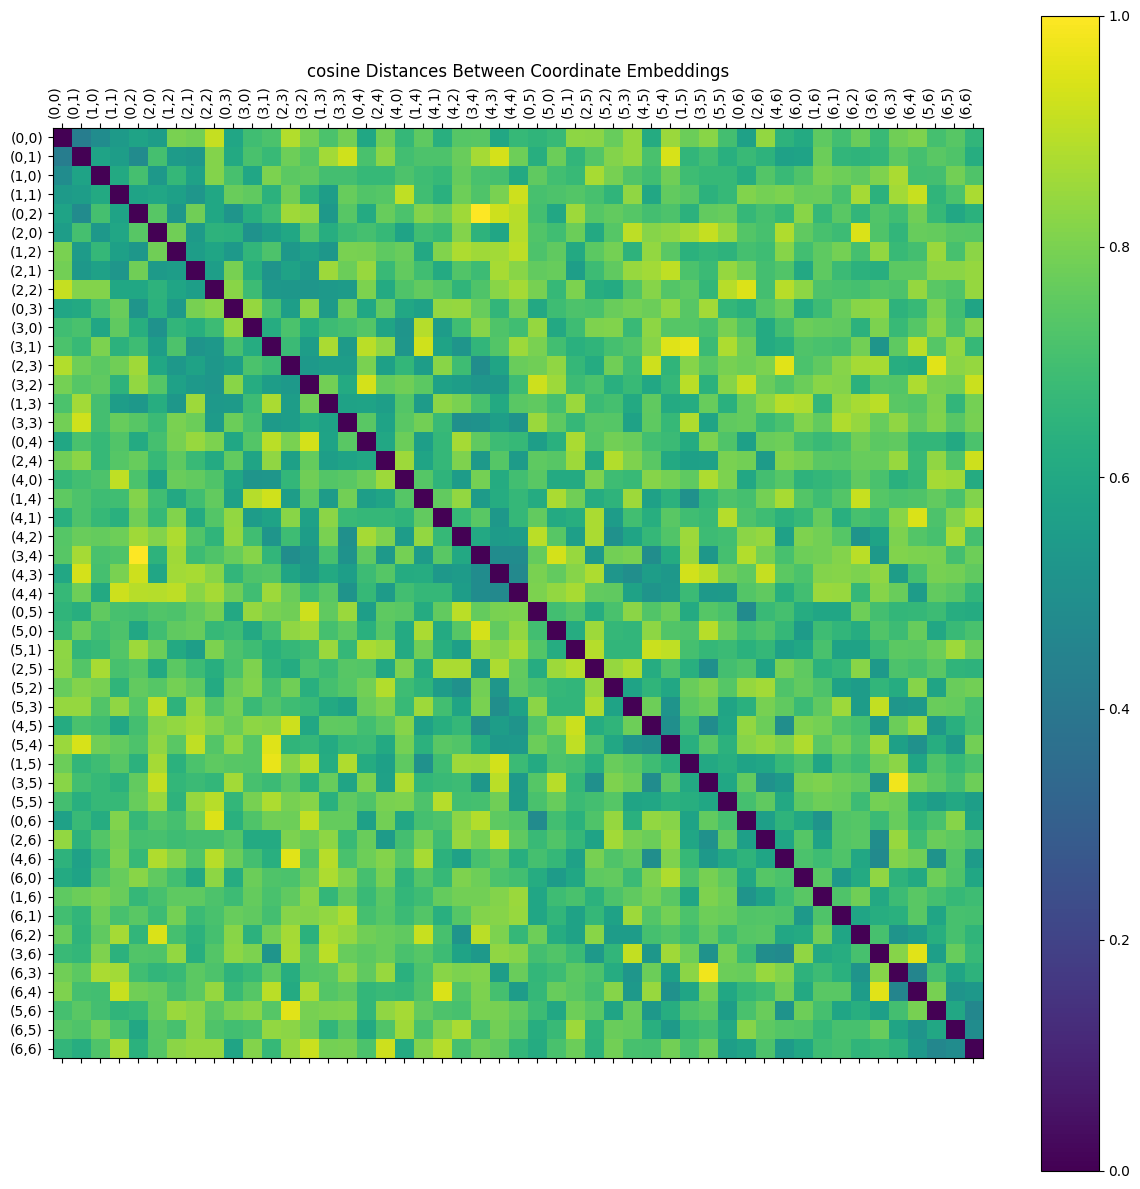

In [7]:
plot_distances_matrix(**distances_result, show=False)
plt.show()

In [8]:
distance_grid: Float[np.ndarray, "n n n n"] = compute_grid_distances(
    embedding_distances_matrix=distances_result["embedding_distances_matrix"],
    tokenizer=TOKENIZER,
)

<Axes: xlabel='cityblock distance between coordinates', ylabel='cosine embedding distance'>

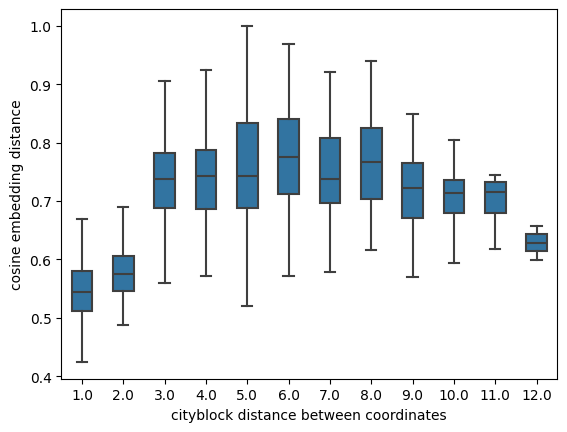

In [9]:
plot_distance_correlation(
    distance_grid,
    embedding_metric=distances_result["embedding_metric"],
    coordinate_metric=distances_result["coordinate_metric"],
)

vbounds = (0.4243861330538615, 1.0)


C:\Users\mivan\AppData\Local\Temp\ipykernel_31704\2386965475.py:14: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



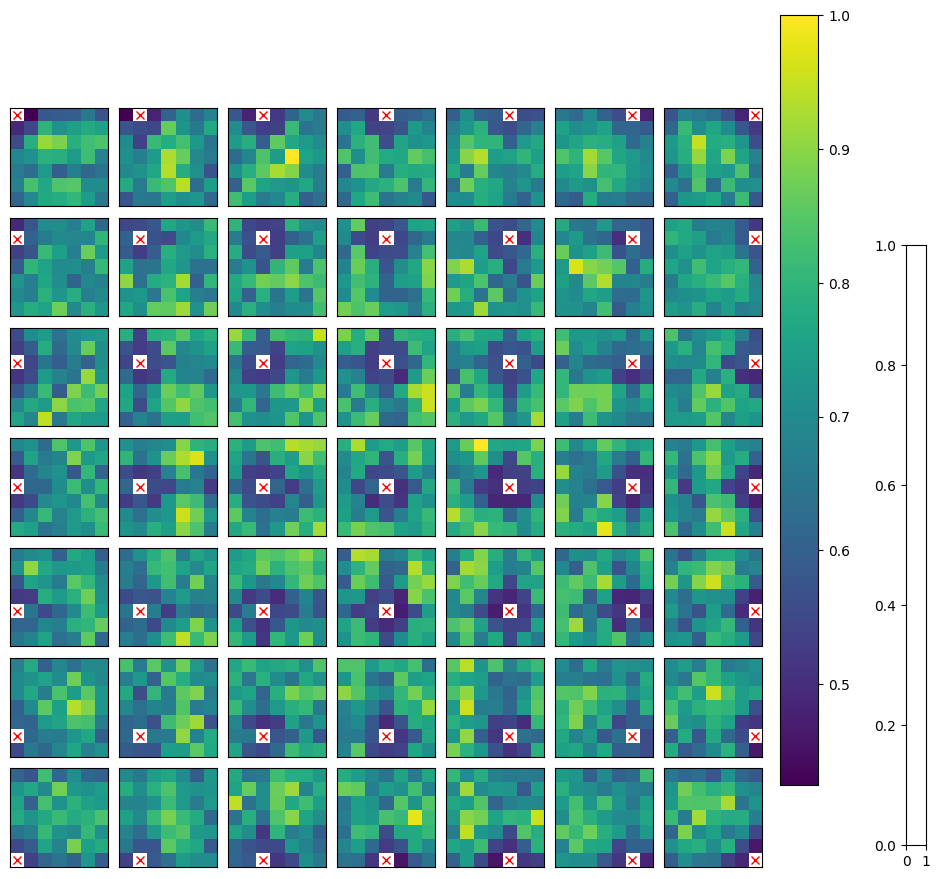

In [39]:
fig, ax, colorbar_ax = plot_distance_grid(
	distance_grid, 
	embedding_metric=distances_result["embedding_metric"], 
	show=False,
	figsize=(10, 10),
)
fig.suptitle(None)
# remove titles and ticks from subplots
for ax in ax.flatten():
	ax.set_title(None)
	ax.set_xticks([])
	ax.set_yticks([])
# tight spacing between subplots
fig.tight_layout(pad=1, w_pad=0.5, h_pad=0.05, rect=[0, 0, 0.78, 0.83])
colorbar_ax.set_position([0.91, 0.05, 0.02, 0.6])
fig.savefig("distance_grid.svg", dpi=300, bbox_inches="tight")
plt.show()


# PCA of token embeddings

In [11]:
# raise Exception("dont run the rest for now")

In [12]:
# compute the PCA
PCA_RESULTS: dict[str, EmbeddingsPCAResult] = compute_pca(
    model=MODEL,
    token_plotting_info=VOCAB_PLOT_INFO,
)

In [13]:
ipywidgets.interact(
    plot_pca_colored, 
    pca_results_options=ipywidgets.fixed(PCA_RESULTS),
    pca_results_key=ipywidgets.Dropdown(
        options=list(PCA_RESULTS.keys()),
        value='all',
        description='PCA Results:',
    ),
    vocab_colors=ipywidgets.fixed(VOCAB_PLOT_INFO), 
    dim1=ipywidgets.IntText(
        value=1,
        description='Dim 1:',
    ),
    dim2=ipywidgets.IntText(
        value=2,
        description='Dim 1:',
    ),
    lattice_connections=ipywidgets.Dropdown(
        options=[True, False],
        value=True,
        description='Show Lattice:',
    ),
    # float or None (entry box of float or text)
    symlog_scale=ipywidgets.FloatText(
        value=-1,
        description='Symlog Scale:',
    ),
    axes_and_centered=ipywidgets.Dropdown(
        options=[True, False],
        value=True,
        description='Center and show axes:',
    ),
);

interactive(children=(Dropdown(description='PCA Results:', options=('all', 'coords_only', 'special_only'), val…